In [5]:
from pathlib import Path
import json

NB_DIR = Path().resolve()
ROOT = NB_DIR.parent
DATA_DIR = Path(ROOT, "data/lane_segmentation_yolo/new")  # folder that contains images + .json files

images = list(DATA_DIR.glob("*.jpg")) + list(DATA_DIR.glob("*.png"))
jsons = list(DATA_DIR.glob("*.json"))

print("Images:", len(images))
print("JSONs:", len(jsons))

# Peek at one JSON
sample = jsons[0]
with open(sample, "r") as f:
    data = json.load(f)

print("Sample keys:", data.keys())
print("Num shapes:", len(data.get("shapes", [])))

Images: 97
JSONs: 97
Sample keys: dict_keys(['version', 'flags', 'shapes', 'imagePath', 'imageData', 'imageHeight', 'imageWidth'])
Num shapes: 1


In [7]:
import json
import shutil

OUT_DIR = DATA_DIR.parent / "yolo"
IMAGES_OUT = OUT_DIR / "images"
LABELS_OUT = OUT_DIR / "labels"

IMAGES_OUT.mkdir(parents=True, exist_ok=True)
LABELS_OUT.mkdir(parents=True, exist_ok=True)

CLASS_ID = 0  # lane

def normalize(x, y, w, h):
    return x / w, y / h

for json_path in DATA_DIR.glob("*.json"):
    with open(json_path) as f:
        data = json.load(f)

    img_name = data["imagePath"]
    img_path = DATA_DIR / img_name
    if not img_path.exists():
        continue

    shutil.copy(img_path, IMAGES_OUT / img_name)

    h, w = data["imageHeight"], data["imageWidth"]
    label_lines = []

    for shape in data["shapes"]:
        if shape["label"] != "lane":
            continue

        pts = []
        for x, y in shape["points"]:
            nx, ny = normalize(x, y, w, h)
            pts.extend([nx, ny])

        label_lines.append(
            " ".join([str(CLASS_ID)] + [f"{p:.6f}" for p in pts])
        )

    with open(LABELS_OUT / f"{img_path.stem}.txt", "w") as f:
        for line in label_lines:
            f.write(line + "\n")

print("LabelMe → YOLO-seg conversion done.")

LabelMe → YOLO-seg conversion done.


(np.float64(-0.5), np.float64(1535.5), np.float64(2047.5), np.float64(-0.5))

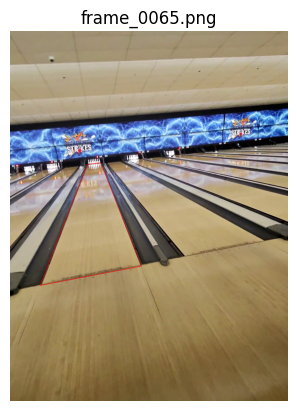

In [17]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

img_paths = list(IMAGES_OUT.glob("*.jpg")) + list(IMAGES_OUT.glob("*.png"))
img_path = random.choice(img_paths)

lbl_path = LABELS_OUT / f"{img_path.stem}.txt"

img = cv2.imread(str(img_path))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, _ = img.shape

if lbl_path.exists() and lbl_path.stat().st_size > 0:
    with open(lbl_path) as f:
        for line in f:
            parts = list(map(float, line.strip().split()))
            pts = parts[1:]
            pts = np.array(
                [(int(pts[i] * w), int(pts[i+1] * h)) for i in range(0, len(pts), 2)],
                dtype=np.int32
            )
            cv2.polylines(img, [pts], isClosed=True, color=(255, 0, 0), thickness=2)

plt.title(img_path.name)
plt.imshow(img)
plt.axis("off")

In [18]:
from pathlib import Path
import yaml

DATA_YAML = Path(ROOT, "data/lane_segmentation_yolo/dataset.yaml")

yaml_dict = {
    "path": str(OUT_DIR),          # yolo_format root
    "train": "images",             # YOLO will split internally if not specified
    "val": "images",
    "names": {
        0: "lane"
    }
}

with open(DATA_YAML, "w") as f:
    yaml.dump(yaml_dict, f, sort_keys=False)

print("Wrote:", DATA_YAML)


Wrote: C:\Users\jleto\Projects\rev-vision\data\lane_segmentation_yolo\dataset.yaml


In [33]:
from ultralytics import YOLO

model = YOLO("yolov8n-seg.pt")

model.train(
    data=str(DATA_YAML),
    epochs=50,
    imgsz=640,
    batch=8,
    workers=0
)


New https://pypi.org/project/ultralytics/8.4.5 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.241  Python-3.12.10 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\jleto\Projects\rev-vision\data\lane_segmentation_yolo\dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, m

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000272B1C4CF20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.0410

(np.float64(-0.5), np.float64(479.5), np.float64(639.5), np.float64(-0.5))

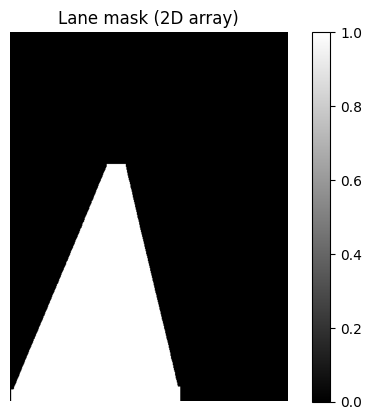

In [44]:
# Predict + visualize mask on a random image

from ultralytics import YOLO
import random, cv2, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.insert(0, str(ROOT))
from config import LANE_MODEL

# load trained model (auto-find best.pt)
# weights = list(Path("runs/segment").rglob("best.pt"))[0]
model = YOLO(Path(ROOT, LANE_MODEL))

# pick random image
img_paths = list(IMAGES_OUT.glob("*.jpg")) + list(IMAGES_OUT.glob("*.png"))
img_path = random.choice(img_paths)

# run inference
res = model.predict(source=str(img_path), conf=0.25, verbose=False)[0]

# load image
img = cv2.imread(str(img_path))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# # overlay mask(s)
# if res.masks is not None:
#     for m in res.masks.xy:
#         pts = np.array(m, dtype=np.int32)
#         cv2.polylines(img, [pts], True, (255, 0, 0), 2)

# plt.title(img_path.name)
# plt.imshow(img)
# plt.axis("off")

mask = res.masks.data[0].cpu().numpy()  # H x W, values in [0,1]

plt.imshow(mask, cmap="gray")
plt.title("Lane mask (2D array)")
plt.colorbar()
plt.axis("off")